In [2]:
### Tries to select subpoints of the object (e.g. grabbing a marker by the cap, or elsewhere)

import pickle
import time

import cv2
import PIL.Image as Image
import segment_point_cloud
from detect_grasps import detect_grasps
from generate_object_candidates import detect as detect_objects_2d
from matplotlib import pyplot as plt
from matplotlib import patches as mpatches
from set_axes_equal import set_axes_equal

def smoothen_pcd(pcd):
    pcd_smooth = cv2.GaussianBlur(pcd, (5, 5), 2) # type: ignore
    pcd_smooth[pcd == -10000] = -10000
    return pcd_smooth


In [3]:
capture_num = 3
with open(f"capture_{capture_num}.pkl", "rb") as f:
    (rgbs, pcds) = pickle.load(f)

# adjust point clouds
# pcds = [smoothen_pcd(pcd) for pcd in pcds]
mask0 = pcds[0] == -10000
mask1 = pcds[1] == -10000
pcds[0][..., 0] += 0.05
pcds[0][..., 2] += 0.015
pcds[1][..., 2] += 0.015

pcds[0][mask0] = -10000
pcds[1][mask1] = -10000

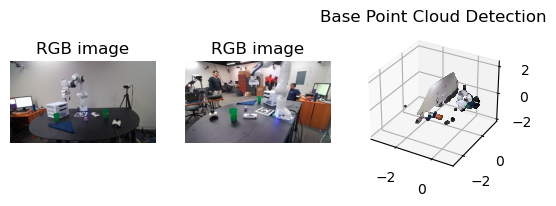

In [4]:
# Render test
render_pcd = pcds[0]
mask = ~(render_pcd == -10000).any(axis=-1)
render_pcd = render_pcd[mask]
color = rgbs[0][mask]
fig = plt.figure()

ax = fig.add_subplot(1,3,1)
ax.set_title("RGB image")
ax.imshow(rgbs[0])
ax.axis('off')

ax = fig.add_subplot(1,3,2)
ax.set_title("RGB image")
ax.imshow(rgbs[1])
ax.axis('off')

ax = fig.add_subplot(1,3,3,projection='3d')
ax.set_title("Base Point Cloud Detection")
ax.scatter(render_pcd[:, 0], render_pcd[:, 1], render_pcd[:, 2], c=color/255.0, s=0.5)
set_axes_equal(ax)
plt.show()

In [12]:
%matplotlib widget

In [ ]:
# detect a cup
imgs = [Image.fromarray(rgb) for rgb in rgbs]

start_time = time.time()
cup_detections = detect_objects_2d(imgs[0], 'box')
end_time = time.time()
print("### Made 2D Detections with OwlV2 ###")
print("Time:", end_time - start_time)
print("Hz:", 1/(end_time - start_time))

# generate object segmentations
pcd_segmenter = segment_point_cloud.SamPointCloudSegmenter(device='cuda', render_2d_results=False)

fig = plt.figure(dpi=128, figsize=(2, 4))
for i, detection in enumerate(cup_detections):
    box = detection['box']
    x1, y1, x2, y2 = box['xmin'], box['ymin'], box['xmax'], box['ymax']

    start_time = time.time()
    segmented_pcd_xyz, segmented_pcd_color, _segmentation_masks = pcd_segmenter.segment(imgs[0], pcds[0], [x1, y1, x2, y2], [imgs[1]], [pcds[1]])
    end_time = time.time()

    print(f"### Made 3D Object Segmentations with SAM [{i + 1}/{len(cup_detections)}] ###")
    print("Time:", end_time - start_time)
    print("Hz:", 1/(end_time - start_time))

    # render the cup detection
    ax = fig.add_subplot(3, len(cup_detections), 1 + i)
    ax.set_title("2D Segmentation")
    ax.imshow(imgs[0])
    ax.imshow(_segmentation_masks[0], alpha=0.5)
    # Plot the box detection
    # ax.add_patch(mpatches.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False))
    ax.axis('off')
    
    ax = fig.add_subplot(3, len(cup_detections), 1 * len(cup_detections) + 1 + i)
    ax.set_title("2D Segmentation")
    ax.imshow(imgs[1])
    ax.imshow(_segmentation_masks[1], alpha=0.5)
    ax.axis('off')

    # render the segmented point cloud
    ax = fig.add_subplot(3, len(cup_detections), 2 * len(cup_detections) + 1 + i, projection='3d')
    ax.set_title(f"3D Segmentation {i+1}/{len(cup_detections)}")
    ax.scatter(segmented_pcd_xyz[:, 0], segmented_pcd_xyz[:, 1], segmented_pcd_xyz[:, 2], c=segmented_pcd_color/255.0, s=0.5)

    start_time = time.time()

    grasps = detect_grasps(
        segmented_pcd_xyz,
        segmented_pcd_color,
        voxel_size=0.005,
        min_points_in_voxel=2,
        gripper_width=0.2,
        max_alpha=15,
        hop_size=1,
        window_size=2,
        top_k_per_angle=5,
        show_rotated_voxel_grids=False
    )

    end_time = time.time()

    print("### Generated Grasps using Force Closure ###")
    print("Time:", end_time - start_time)
    print("Hz:", 1/(end_time - start_time))

    # detect grasps
    # plot grasp locations
    for grasp in grasps:
        _worst_alpha, start, end = grasp
        (x1, y1, z1) = (start)# - lower_bound) / voxel_size
        (x2, y2, z2) = (end)# - lower_bound) / voxel_size
        ax.scatter(x1, y1, z1, c='r')
        ax.scatter(x2, y2, z2, c='g')
        ax.plot([x1, x2], [y1, y2], [z2, z2], c='b')

    set_axes_equal(ax)

fig.tight_layout()
plt.show()

Detection duration: 0.90
### Made 2D Detections with OwlV2 ###
Time: 0.8976390361785889
Hz: 1.1140335476687602
Segmenting based on bounding box [695.0, 268.0, 814.0, 395.0]
### Made 3D Object Segmentations with SAM [1/1] ###
Time: 0.37236905097961426
Hz: 2.685507824480145
### Generated Grasps using Force Closure ###
Time: 4.529348134994507
Hz: 0.22078232235535872
